In [98]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev, value_and_grad
from skimage.transform import warp
from scipy.ndimage import map_coordinates
from tqdm import tqdm
from jax.experimental import optimizers
import time
from skimage.transform import resize
import math
import skimage
import copy
from scipy.ndimage import gaussian_filter, zoom

In [99]:
circle = np.asarray(nib.load("/Users/ranjak/image_registration/imgreg/circle.nii").dataobj)
square = np.asarray(nib.load("/Users/ranjak/image_registration/imgreg/square.nii").dataobj)

In [100]:
"""circle = resize (circle, (30, 30), anti_aliasing = True)
square = resize (square, (30, 30), anti_aliasing = True)
circle.shape, square.shape"""

'circle = resize (circle, (30, 30), anti_aliasing = True)\nsquare = resize (square, (30, 30), anti_aliasing = True)\ncircle.shape, square.shape'

In [101]:
## utilities function 
def change_resolution(img, resolution, sigma, order=1, ndim = 2):
    """
    change image's resolution
    Parameters
    ----------
    resolution : int
        how much to magnify
        if resolution is 2, the shape of the image will be halved
    sigma : float
        standard deviation of gaussian filter for smoothing
    order : int
        order of interpolation
    Returns
    -------
    img : ScalarImage
        zoomed scalar image
    """
    if resolution != 1:
        blurred_data = gaussian_filter(img, sigma)
        ratio = [1 / float(resolution)] * ndim
        data = zoom(blurred_data, ratio, order=order)
    elif resolution == 1:
        data = gaussian_filter(img, sigma)
    return data

def change_scale(img, maximum_value):
    data = maximum_value * img / np.max(img)
    return data


def zoom_grid(grid, resolution, ndim = 2, shape0 = (120, 120)):
    shape = grid.shape[1:]
    if resolution != 1:
        interpolated_grid = np.zeros((ndim,) + shape0)
        for i in range(ndim):
            interpolated_grid[i] = interpolate_mapping(
                grid[i], np.array(shape0, dtype=np.int32)
            ) * (shape0[i] - 1) / (shape[i] - 1)
        return interpolated_grid
    else:
        return grid

def interpolate_mapping(func,  target_shape):
    return interpolate2d(func, func.shape[0], func.shape[1], target_shape)
    


def interpolate2d( func,  xlen_now,  ylen_now,  target_shape):
    xlen_target = target_shape[0]
    ylen_target = target_shape[1]

    interpolated = np.zeros((xlen_target, ylen_target))

    for x in range(xlen_target):
        xi = x * (xlen_now - 1) / (xlen_target - 1.)
        for y in range(ylen_target):
            yi = y * (ylen_now - 1) / (ylen_target - 1.)
            interpolated[x,y] = bilinear_interpolation(func, xi, yi, xlen_now, ylen_now)

    return interpolated


def bilinear_interpolation(func, x,  y,  xlen,  ylen):
    """
    Bilinear interpolation at a given position in the image.
    Parameters
    ----------
    func : double array
        Input function.
    x, y : double
        Position at which to interpolate.
    Returns
    -------
    value : double
        Interpolated value.
    """

    
    x0 = math.floor(x)
    x1 = math.ceil(x)
    y0 = math.floor(y)
    y1 = math.ceil(y)

    dx = x - x0
    dy = y - y0

    f0 = (1 - dy) * getValue2d(func, x0, y0, xlen, ylen, 'N') + dy * getValue2d(func, x0, y1, xlen, ylen, 'N')
    f1 = (1 - dy) * getValue2d(func, x1, y0, xlen, ylen, 'N') + dy * getValue2d(func, x1, y1, xlen, ylen, 'N')

    return (1 - dx) * f0 + dx * f1


def getValue2d(func,  x,  y,  xlen,  ylen,  mode='N'):
    if mode == 'N':
        if x < 0:
            x = 0
        elif x > xlen - 1:
            x = xlen - 1

        if y < 0:
            y = 0
        elif y > ylen - 1:
            y = ylen - 1
    elif mode == 'C':
        if x < 0 or x > xlen - 1 or y < 0 or y > ylen - 1:
            return 0
    
    return func[x , y]

def show_warp_field(grid, interval=1, shape = (120, 120), size = (8, 8),limit_axis=True, show_axis=False, plot_separately = True):
    
    if plot_separately:
        f, a = plt.subplots(1, 2, figsize = size)
        
        for x in range(0, shape[0], interval):
            a[0].set_axis_off()
            a[0].plot(grid[1, x, :], grid[0, x, :], 'k')
            a[0].invert_yaxis()
            a[0].set_title("x field")
            a[0].set_aspect("equal")
        for y in range(0, shape[1], interval):
            a[1].set_axis_off()
            a[1].set_title("y field")
            a[1].plot(grid[1, :, y], grid[0, :, y], 'r')
            a[1].invert_yaxis()
            a[1].set_aspect("equal")
        plt.show()
    else:
        plt.figure(figsize = size)
        if show_axis is False:
            plt.axis('off')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.set_aspect('equal')
        for x in range(0, shape[0], interval):
            plt.plot(grid[1, x, :], grid[0, x, :], 'k')
        for y in range(0, shape[1], interval):
            plt.plot(grid[1, :, y], grid[0, :, y], 'k')
        plt.show()


In [102]:
def plotx(im1, im2):
    f, a = plt.subplots(1, 2, figsize  = (8, 8))
    a[0].imshow(im1)
    a[0].set_axis_off()
    a[1].imshow(im2)
    a[1].set_axis_off()
    plt.show()

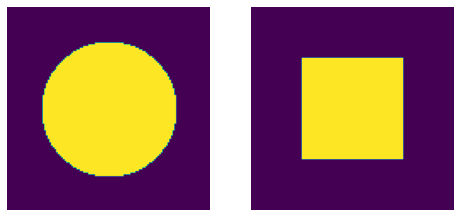

In [103]:
f, a = plt.subplots(1, 2, figsize  = (8, 8))
a[0].imshow(circle)
a[0].set_axis_off()
a[1].imshow(square)
a[1].set_axis_off()
plt.show()

In [163]:
def identity_mapping(shape):
    x1 = [float(i) for i in range(shape[0])]
    y1 = [float(i)for i in range(shape[1])]
    return jax.numpy.meshgrid(x1, y1, indexing = "xy")
    

def similarity(phi, square, circle, sigma = 4):
    
    warped = jax.scipy.ndimage.map_coordinates(circle, phi, order=1)
    sim = (sigma**-2) *jnp.sum(jnp.square((warped - square)))
    return sim


def compute_laplacian(grid, stencil = jnp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])):
    laplaced = jax.scipy.signal.convolve2d(grid, stencil)
    return laplaced 

def laplacian(phi, square, circle):
    v1, v2 = phi[0] - identity_mapping(circle.shape)[0], phi[1] - identity_mapping(circle.shape)[1] 
    l1 = compute_laplacian(v1)[2:,:-2]
    
    l2 = compute_laplacian(v2)[2:,:-2]
    #print (l1.shape, l2.shape)
    delta = jnp.sum(jnp.asarray([l1, l2]))
    return delta, v1, v2
    
    
def regularization(phi, square, circle, alpha = 3, gamma = 4.5):
    delta, vx, vy = laplacian(phi, square, circle)
    v_arr = jnp.asarray([vx, vy])
    v_total = jnp.sum(jnp.square(jnp.multiply(-alpha, delta) + jnp.multiply(gamma, v_arr)))
    #print (v_total)
    return v_total
    

def ssd_matrix(im1, im2):
    sim = jnp.square((im1 - im2))
    return sim


def cost_term1(phi, square, circle):
    c1 = similarity(phi, square, circle)
    reg = regularization(phi, square, circle)
    return c1+reg

In [164]:
def optimize(func, circle_warped_res, square_res, step_size, num_epochs):

    opt_init, opt_update, get_params = optimizers.adam(step_size)
    params = identity_mapping(circle_warped_res.shape)
    opt_state = opt_init(params)

    loss = []
    for epoch in tqdm(range(num_epochs)):
        value, grads = value_and_grad(func)(get_params(opt_state), square_res, circle_warped_res)
        opt_state = opt_update(epoch, grads, opt_state)
        params = get_params(opt_state)
        loss.append(value)  
    return opt_state, loss, get_params

resolution 4
Image at the start of optimization (30, 30) (30, 30)


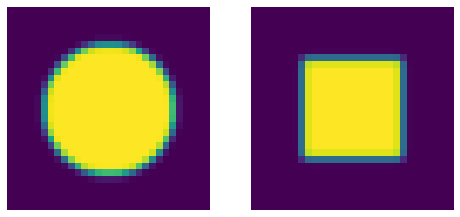

100%|██████████| 50/50 [00:01<00:00, 26.93it/s]


Warped Image original size after optimization (120, 120) (120, 120)


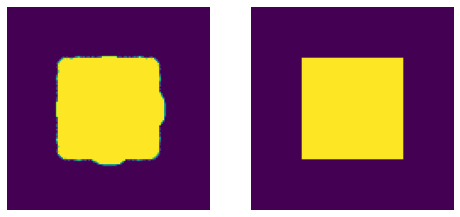

resolution 2
Image at the start of optimization (60, 60) (60, 60)


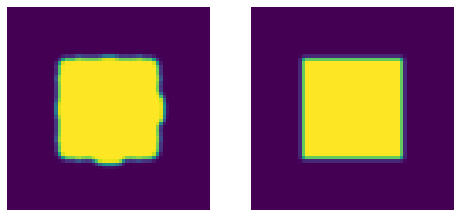

100%|██████████| 20/20 [00:00<00:00, 27.97it/s]


Warped Image original size after optimization (120, 120) (120, 120)


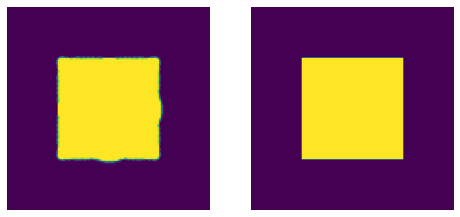

resolution 1
Image at the start of optimization (120, 120) (120, 120)


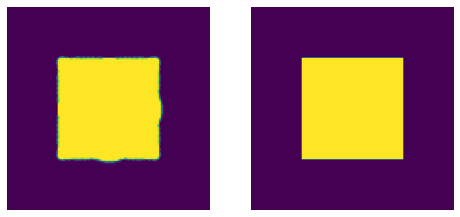

100%|██████████| 50/50 [00:02<00:00, 24.73it/s]

Warped Image original size after optimization (120, 120) (120, 120)


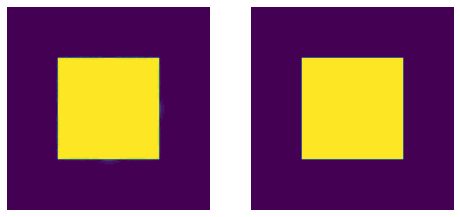

In [165]:
step_size = 0.05
params = identity_mapping(circle.shape)
circle_warped = jax.scipy.ndimage.map_coordinates(circle, params, order = 1)
losses = []
n_iters = (50, 20, 50)
resolutions = (4, 2, 1)
smoothing_sigmas=(2, 1, 0)
warp_total = copy.deepcopy(params)

for n_iter, resolution, sigma in zip(n_iters,
                                        resolutions,
                                        smoothing_sigmas):
    print ("=======================================")
    print ("resolution", resolution)
    
    ## map at one resolution
    ## zoom grid 
    ## map the old image to new and then repeat 
    
    circle_warped_res = change_resolution(circle_warped, resolution, sigma)
    square_res = change_resolution(square, resolution, sigma)
    
    print ("Image at the start of optimization", circle_warped_res.shape, square_res.shape)
    plotx(circle_warped_res, square_res)
    
    opt_state, loss, get_params = optimize(cost_term1, circle_warped_res, square_res, step_size, n_iter)
    params = get_params(opt_state)
    params_new = zoom_grid(np.asarray(params), resolution, ndim = 2, shape0 = (120, 120))
    
    warp_total = warp_total + params_new
    
    circle_warped = map_coordinates(circle_warped, params_new, order = 1)
    
    losses.append(np.asarray(loss)[0])
    
    print ("Warped Image original size after optimization", circle_warped.shape, square.shape)
    plotx(circle_warped, square)
    

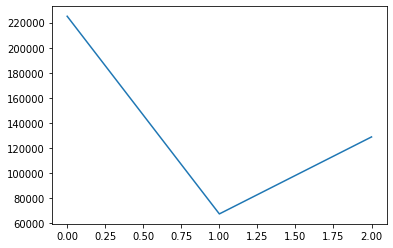

In [166]:
plt.plot(losses)

In [167]:
sim_matrix = (np.asarray(ssd_matrix(circle_warped, square)))

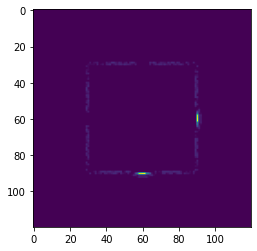

In [168]:
plt.imshow(sim_matrix)

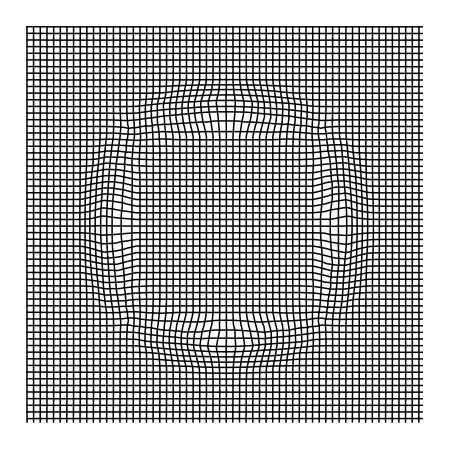

In [169]:
show_warp_field(warp_total, size = (8, 8), interval = 2, plot_separately = False)

In [49]:
warp_total1 = warp_total

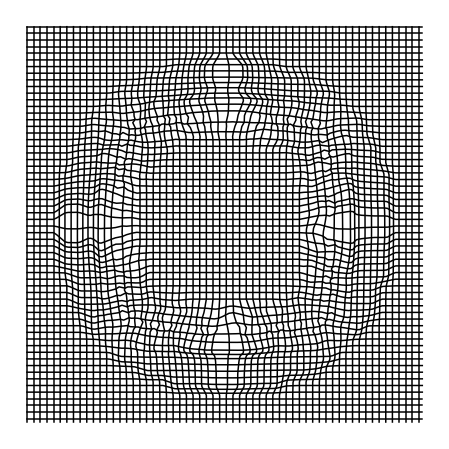

In [13]:
show_warp_field(warp_total, size = (8, 8), interval = 2, plot_separately = False)